# COMS W4705 - Homework 3
## Conditioned LSTM Language Model for Image Captioning
Olivia Caulfield <ogc2111@columbia.edu>

Follow the instructions in this notebook step-by step. Much of the code is provided (especially in part I, II, and III), but some sections are marked with **todo**. Make sure to complete all these sections.

Specifically, you will build the following components:

* Part I (14pts): Create encoded representations for the images in the flickr dataset using a pretrained image encoder(ResNet)
* Part II (14pts): Prepare the input caption data.
* Part III (24pts): Train an LSTM language model on the caption portion of the data and use it as a generator.
* Part IV (24pts): Modify the LSTM model to also pass a copy of the input image in each timestep.
* Part V (24pts): Implement beam search for the image caption generator.

As for homework 4, access to a GPU is required.

### Getting Started

There are a few required packages.

In [1]:
import os
import PIL # Python Image Library

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import ResNet18_Weights

import gc

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
    print("You won't be able to train the RNN decoder on a CPU, unfortunately.")
print(DEVICE)

cuda


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail:

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

If you are using Colab:
* The data is available on google drive. You can access the folder here:
https://drive.google.com/drive/folders/1sXWOLkmhpA1KFjVR0VjxGUtzAImIvU39?usp=sharing
* Sharing is only enabled for the lionmail domain. Please make sure you are logged into Google Drive using your Columbia UNI. I will not be able to respond to individual sharing requests from your personal account.

* Once you have opened the folder, click on "Shared With Me", then select the hw5data folder, and press shift+z. This will open the "add to drive" menu. Add the folder to your drive. (This will not create a copy, but just an additional entry point to the shared folder).

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the dataset beyond this course, I suggest that you submit your own download request here (it's free): https://forms.illinois.edu/sec/1713398



If you are running the code locally (or on a cloud VM): I also placed a copy in a Google cloud storage bucket here:
https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip

In [3]:
# OPTIONAL (if not using Colab and the data in Google Drive): Download the data.
#!wget https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip

In [4]:
#Then unzip the data
#!unzip hw3data.zip

The following variable should point to the location where the data is located.

In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
MY_DATA_DIR="/content/drive/My Drive/Fall 2024/COMS4705 -- NLP/hw5data"

## Part I: Image Encodings (14 pts)

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists.

In [8]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f:
        return [line.strip() for line in image_list_f]

In [9]:
FLICKR_PATH="/content/drive/My Drive/Fall 2024/COMS4705 -- NLP/hw5data/"

In [10]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

Let's see how many images there are

In [11]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [12]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [13]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

We can use PIL to open and display the image:

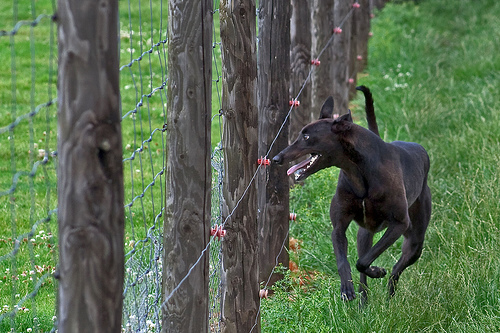

In [14]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

### Preprocessing

We are going to use an off-the-shelf pre-trained image encoder, the ResNet-18 network. Here is more detail about this model (not required for this project):

> Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778
> https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

The model was initially trained on an object recognition task over the ImageNet1k data. The task is to predict the correct class label for an image, from a set of 1000 possible classes.

To feed the flickr images to ResNet, we need to perform the same normalization that was applied to the training images. More details here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [15]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The resulting images, after preprocessing, are (3,224,244) tensors, where the first dimension represents the three color channels, R,G,B).

In [16]:
processed_image = preprocess(image)
processed_image.shape

torch.Size([3, 224, 224])

To the ResNet18 model, the images look like this:

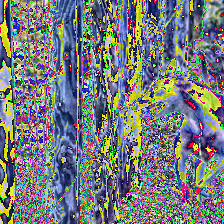

In [17]:
transforms.ToPILImage()(processed_image)

### Image Encoder
Let's instantiate the ReseNet18 encoder. We are going to use the pretrained weights available in torchvision.

In [18]:
img_encoder = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.8MB/s]


In [19]:
img_encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 512.

We will use the following hack: remove the last layer, then reinstantiate a Squential model from the remaining layers.

In [20]:
lastremoved = list(img_encoder.children())[:-1]
img_encoder = torch.nn.Sequential(*lastremoved).to(DEVICE) # also send it to GPU memory
img_encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Let's try the encoder.

In [21]:
def get_image(img_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, img_name))
    return preprocess(image)

In [22]:
preprocessed_image = get_image(train_list[0])
encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # unsqueeze required to add batch dim (3,224,224) becomes (1,3,224,224)
encoded.shape

torch.Size([1, 512, 1, 1])

The result isn't quite what we wanted: The final representation is actually a 1x1 "image" (the first dimension is the batch size).
We can just grab this one pixel:

In [23]:
encoded = encoded[:,:,0,0] #this is our final image encoded
encoded.shape

torch.Size([1, 512])

**TODO:** Because we are just using the pretrained encoder, we can simply encode all the images in a preliminary step. We will store them in one big tensor (one for each dataset, train, dev, test). This will save some time when training the conditioned LSTM because we won't have to recompute the image encodings with each training epoch. We can also save the tensors to disk so that we never have to touch the bulky image data again.

Complete the following function that should take a list of image names and return a tensor of size [n_images, 512] (where each row represents one image).

For example `encode_imates(train_list)` should return a [6000,512] tensor.

In [24]:
def encode_images(image_list):
  encoded_images = torch.zeros((6000, 512), device=DEVICE) # create tensor of zeros stored on DEVICE (gpu)
  image_count = 0 # create count for images

  # for each image in the list
  for i in image_list:
      preprocessed_image = get_image(i) # get preprocessed image

      with torch.no_grad():
        encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # encode each image

      encoded = encoded[:,:,0,0] # extract 512-dim vector
      encoded_images[image_count] = encoded # store encoded image in inital tensor
      image_count = image_count + 1

  return encoded_images

#enc_images_train = encode_images(train_list)
#enc_images_train.shape

# make sure to save locally so that you dont have to rerun everytime

**Commented out so that I don't rerun everytime when restarting colab since I saved encoded images to my google drive with the lines below**

We can now save this to disk:

In [25]:
#enc_images_path = "/content/encoded_images_train.pt"
#torch.save(enc_images_train, open(enc_images_path,'wb'))

#from google.colab import files
#files.download("/content/encoded_images_train.pt")

It's a good idea to save the resulting matrices, so we do not have to run the encoder again.

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the language model. We will train a text-only model first.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file.
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a \<START\> token on the left and an \<END\> token on the right.

For example, a single caption might look like this:
['\<START\>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '\<EOS\>'],

In [26]:
def read_image_descriptions(filename):
    # dictionary: key = image filenames, value = list of 5 captions
    image_descriptions = {}

    with open(filename,'r') as in_file:

      for i in in_file:
        key = i.split('#')[0] # key
        caption = i.split('\t')[1] # caption

        tokens = []
        tokens.append("<START>")

        # tokenized caption converted to lowercase
        for token in caption.split():
          token = token.lower()
          tokens.append(token)

        tokens.append("<EOS>")

        if key not in image_descriptions:
          image_descriptions[key] = []
        image_descriptions[key].append(tokens)

    return image_descriptions

In [27]:
os.path.join(FLICKR_PATH, "Flickr8k.token.txt")

'/content/drive/My Drive/Fall 2024/COMS4705 -- NLP/hw5data/Flickr8k.token.txt'

In [28]:
descriptions = read_image_descriptions(os.path.join(FLICKR_PATH, "Flickr8k.token.txt"))

In [29]:
descriptions['1000268201_693b08cb0e.jpg']

[['<START>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'girl',
  'going',
  'into',
  'a',
  'wooden',
  'building',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'into',
  'a',
  'wooden',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'the',
  'stairs',
  'to',
  'her',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'in',
  'a',
  'pink',
  'dress',
  'going',
  'into',
  'a',
  'wooden',
  'cabin',
  '.',
  '<EOS>']]

The previous line shoudl return
<pre>[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<EOS>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<EOS>']]</pre>

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input
and output sequences using numeric representations.

**TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. This is similar to the word indices you created for homework 3 and 4.  

Make sure you create word indices for the three special tokens `<PAD>`, `<START>`, and `<EOS>` (end of sentence).

In [30]:
# maps numeric ids to tokens
id_to_word = {}
id_to_word[0] = "<PAD>"
id_to_word[1] = "<START>"
id_to_word[2] = "<EOS>"

# maps tokens to numeric ids
word_to_id = {}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<EOS>"] = 2

# intial index after special tokens
index = 3

# for each token in the image descriptions
for image in descriptions:
  for description in descriptions[image]:
    for token in description:
      # map the token to id and id to token
      # if not already in dictionary
      if token not in word_to_id:
        word_to_id[token] = index
        id_to_word[index] = token
        index = index + 1

In [33]:
word_to_id['<START>'] # should print an integer

1

In [32]:
id_to_word[1] # should print a token

'<START>'

Note that we do not need an UNK word token because we will only use the model as a generator, once trained.

## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input.

We will use the LSTM implementation provided by PyTorch. The core idea here is that the recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different position, but the weights for these positions are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [34]:
MAX_LEN = max(len(description) for image_id in train_list for description in descriptions[image_id])
MAX_LEN

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word.
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence

`['<START>', 'a', 'black', 'dog', '<EOS>']`

We would train the model using the following input/output pairs (note both sequences are padded to the right up to MAX_LEN)

| i | input                                 | output                              |
|---|---------------------------------------|-------------------------------------|
| 0 |[`<START>`,`<PAD>`,`<PAD>`,`<PAD>`,...]| [`a`,`<PAD>`,`<PAD>`,`<PAD>`,...    |  
| 1 |[`<START>`,`a`,`<PAD>`,`<PAD>`,...]    | [`a`,`black`,`<PAD>`,`<PAD>`,...    |
| 2 |[`<START>`,`a`,`black`,`<PAD>`,...]    | [`a`,`black`,`dog`,`<PAD>`,...      |
| 3 |[`<START>`,`a`,`back`,`dog`,...]       | [`a`,`black`,`dog`,`<EOS>`,...      |

Here is the lange model in pytorch. We will choose input embeddings of dimensionality 512 (for simplicitly, we are not initializing these with pre-trained embeddings here). We will also use 512 for the hidden state vector and the output.

In [35]:
from torch import nn

vocab_size = len(word_to_id)+1
class GeneratorModel(nn.Module):

    def __init__(self):
        super(GeneratorModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(512, 512, num_layers = 1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512,vocab_size)

    def forward(self, input_seq):
        hidden = self.lstm(self.embedding(input_seq))
        out = self.output(hidden[0])
        return out

The input sequence is an integer tensor of size `[batch_size, MAX_LEN]`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with '<PAD>'.

For each input example, the model returns a distribution over possible output words. The model output is a tensor of size `[batch_size, MAX_LEN, vocab_size]`. vocab_size is the number of vocabulary words, i.e. len(word_to_id)

### Creating a Dataset for the text training data

**TODO**: Write a Dataset class for the text training data. The __getitem__ method should return an (input_encoding, output_encoding) pair for a single item. Both input_encoding and output_encoding should be tensors of size `[MAX_LEN]`, encoding the padded input/output sequence as illustrated above.

I recommend to first read in all captions in the __init__ method and store them in a list. Above, we used the get_image_descriptions function to load the image descriptions into a dictionary. Iterate through the images in img_list, then access the corresponding captions in the `descriptions` dictionary.

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc.


In [36]:
MAX_LEN = 40

class CaptionDataset(Dataset):

    def __init__(self, img_list):

        # iterates through images and stores captions for each image in list
        self.data = []
        for i in img_list:
          self.data.append(descriptions[i])

    def __len__(self):
        return len(self.data)

    def __getitem__(self,k):
      # initialize tensors of size MAX_LEN for word ids
        input_enc = torch.zeros(MAX_LEN, dtype=torch.int64)
        output_enc = torch.zeros(MAX_LEN, dtype=torch.int64)

        # for each caption in set of captions, data[k]
        for caption in self.data[k]:

          # for each index in the range caption
          for i in range(len(caption)-1):

            # create input and output pairs of len MAX_LEN
            input = caption[0:i+1] + ["<PAD>"]*(MAX_LEN-i-1)
            output = caption[1:i+2] + ["<PAD>"]*(MAX_LEN-i-1)

            ''' UNSURE OF THIS TENSOR since im inside a doubly nested for loop'''
            # store the id of each token in the input/output pairs in their respective tensor
            input_enc = torch.tensor([word_to_id[token] for token in input], dtype=torch.int64)
            output_enc = torch.tensor([word_to_id[token] for token in output], dtype=torch.int64)

        return input_enc, output_enc

Let's instantiate the caption dataset and get the first item. You want to see something like this:

for the input:
<pre>
tensor([   1,   74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922,
        7125,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>
for the output:
<pre>
    tensor([  74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922, 7125,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>

In [37]:
data = CaptionDataset(train_list)

In [38]:
i, o = data[0]
i

tensor([  1,  48,  49, 120, 125,   3, 522, 626, 264,  12, 144,  17,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [39]:
o

tensor([ 48,  49, 120, 125,   3, 522, 626, 264,  12, 144,  17,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

Let's try the model:

In [40]:
model = GeneratorModel().to(DEVICE)

In [41]:
model(i.to(DEVICE)).shape   # should return a [40, vocab_size]  tensor.

torch.Size([40, 8922])

### Training the Model

The training function is identical to what you saw in homework 3 and 4.

In [42]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        inputs,targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        # Run the forward pass of the model
        logits = model(inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

Run the training until the accuracy reaches about 0.5 (this would be high for a language model on open-domain text, but the image caption dataset is comparatively small and closed-domain). This will take about 5 epochs.

In [43]:
epochs = 6

for i in range(epochs):
  print("Epoch ", i, ":")
  train()

Epoch  0 :
Current average loss: 9.100305557250977
Current average loss: 5.056103812585963
Current average loss: 4.558126513637713
Current average loss: 4.3274259432605735
Training loss epoch: 4.207476707458496
Average accuracy epoch: 0.29
Epoch  1 :
Current average loss: 3.09087872505188
Current average loss: 3.344651691984422
Current average loss: 3.3259403290440193
Current average loss: 3.3183634098978136
Training loss epoch: 3.2958958581288655
Average accuracy epoch: 0.35
Epoch  2 :
Current average loss: 2.766573190689087
Current average loss: 2.8383778888400237
Current average loss: 2.859026644360367
Current average loss: 2.8626943149439916
Training loss epoch: 2.86909734471639
Average accuracy epoch: 0.38
Epoch  3 :
Current average loss: 2.3556723594665527
Current average loss: 2.4512782214891793
Current average loss: 2.4589346510853933
Current average loss: 2.4767051360931904
Training loss epoch: 2.493962849934896
Average accuracy epoch: 0.42
Epoch  4 :
Current average loss: 1.9

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>", "<PAD>","<PAD>"...]`, use the model to predict the most likely word in the next position. Append the word to the input sequence and then continue until `"<EOS>"` is predicted or the sequence reaches `MAX_LEN` words.

In [44]:
import numpy as np

In [45]:
def decoder():
    # start sequence
    sequence = ["<START>"]

    # until <EOS> or MAX_LEN
    while len(sequence) < MAX_LEN:
      if sequence[len(sequence)-1] == "<EOS>":
        break

      # encode the sequence using word_to_id
      with torch.no_grad():
        sequence_enc = torch.tensor([word_to_id[token] for token in sequence], dtype=torch.int64)

        # calculate predictions using model
        next_id = model(sequence_enc.to(DEVICE))
        next_id = next_id.to('cpu')

      # get index of most likely element
      max_idx = np.argmax(next_id[len(sequence)-1]).item()

      # get word and add to the sequence
      sequence.append(id_to_word[max_idx])

    return sequence

In [46]:
print(decoder())

['<START>', 'a', 'young', 'girl', 'in', 'a', 'pink', 'shirt', 'jumps', 'in', 'the', 'air', 'with', 'a', 'stick', '.', '<EOS>']


this will return something like
['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'dress',
 'walks',
 'by',
 'a',
 'small',
 'white',
 'building',
 '.',
 '<EOS>']

This simple decoder will of course always predict the same sequence (and it's not necessarily a good one).

**TODO:** Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Make sure to apply torch.softmax() to convert the output activations into a distribution.

To sample fromt he distribution, I recommend you take a look at [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), which takes the distribution as a parameter p.

In [47]:
def sample_decoder():
    # start sequence
    sequence = ["<START>"]

    # until <EOS> or MAX_LEN
    while len(sequence) < MAX_LEN:
      if sequence[len(sequence)-1] == "<EOS>":
        break

      # encode the sequence using word_to_id
      with torch.no_grad():
        sequence_enc = torch.tensor([word_to_id[token] for token in sequence], dtype=torch.int64)

        # calculate predictions using model
        next_id = model(sequence_enc.to(DEVICE))
        # apply softmax to convert outputs into a distribution
        next_id = torch.softmax(next_id, dim=-1)
        # move to cpu and convert to numpy array
        next_id = next_id.to('cpu').numpy()

      # sample from the distribution
      next_idx = np.random.choice(len(next_id[len(sequence)-1]), p=next_id[len(sequence)-1])

      # get word and add to the sequence
      sequence.append(id_to_word[next_idx])

    return sequence

for i in range(5):
  print(sample_decoder())

['<START>', 'a', 'man', 'wearing', 'an', 'orange', 'helmet', 'climbing', 'a', 'yellow', 'pyramid', '.', '<EOS>']
['<START>', 'two', 'dogs', 'running', 'side', 'by', 'the', 'tent', 'side', 'of', 'the', 'water', '.', '<EOS>']
['<START>', 'a', 'young', 'child', 'plays', 'an', 'extreme', 'drooping', 'in', 'water', '.', '<EOS>']
['<START>', 'two', 'large', 'women', 'to', 'nose', 'for', 'the', 'camera', '.', '<EOS>']
['<START>', 'a', 'man', 'with', 'a', 'member', 'of', 'osme', '.', '<EOS>']


Some example outputs (it's stochastic, so your results will vary

<pre>
['<START>', 'people', 'on', 'rocky', 'ground', 'swinging', 'basketball', '<EOS>']
['<START>', 'the', 'two', 'hikers', 'take', 'a', 'tandem', 'leap', 'while', 'another', 'is', 'involving', 'watching', '.', '<EOS>']
['<START>', 'a', 'man', 'attached', 'to', 'a', 'bicycle', 'rides', 'a', 'motorcycle', '.', '<EOS>']
['<START>', 'a', 'surfer', 'is', 'riding', 'a', 'wave', 'in', 'the', 'ocean', '.', '<EOS>']
['<START>', 'a', 'child', 'plays', 'in', 'a', 'round', 'fountain', '.', '<EOS>']
</pre>

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input.

## Part IV - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image.

We will concatenate the 512-dimensional image representation to each 512-dimensional token embedding. The LSTM will therefore see input representations of size 1024.

**TODO**: Write a new Dataset class for the combined image captioning data set. Each call to __getitem__ should return a triple  (image_encoding, input_encoding, output_encoding) for a single item. Both input_encoding and output_encoding should be tensors of size [MAX_LEN], encoding the padded input/output sequence as illustrated above. The image_encoding is the size [512] tensor we pre-computed in part I.

Note: One tricky issue here is that each image corresponds to 5 captions, so you have to find the correct image for each caption. You can create a mapping from image names to row indices in the image encoding tensor. This way you will be able to find each image by it's name.

In [48]:
MAX_LEN = 40

class CaptionAndImage(Dataset):

    def __init__(self, img_list):

        # load the image encodings
        self.img_data = torch.load(open("/content/drive/My Drive/Fall 2024/COMS4705 -- NLP/encoded_images_train.pt",'rb'))
        # map images to their row in the image tensor
        self.img_name_to_id = dict([(i,j) for (j,i) in enumerate(img_list)])

        # iterate through images and store captions for each image in the list
        self.data = []
        # add (image, caption) tuples to data
        # each image will have 5 captions
        for image in img_list:
          for caption in descriptions[image]:
            self.data.append((image, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self,k):
        # initialize tensors of size MAX_LEN for word ids
        input_enc = torch.zeros(MAX_LEN, dtype=torch.int64)
        output_enc = torch.zeros(MAX_LEN, dtype=torch.int64)

        name = self.data[k][0]          # image name
        caption = self.data[k][1]       # image caption
        id = self.img_name_to_id[name]  # image id
        img_data = self.img_data[id]    # image data

        # for each index in the range caption
        for i in range(len(caption)-1):

          # create input and output pairs of len MAX_LEN
          input = caption[0:i+1] + ["<PAD>"]*(MAX_LEN-i-1)
          output = caption[1:i+2] + ["<PAD>"]*(MAX_LEN-i-1)

          # store the id of each token in the input/output pairs in their respective tensor
          input_enc = torch.tensor([word_to_id[token] for token in input], dtype=torch.int64)
          output_enc = torch.tensor([word_to_id[token] for token in output], dtype=torch.int64)

        return img_data, input_enc, output_enc

In [49]:
joint_data = CaptionAndImage(train_list)
img, i, o = joint_data[0]
img.shape # should return torch.Size([512])

<ipython-input-48-6fc75ff7e8e0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.img_data = torch.load(open("/content/drive/My Drive/Fall 2024/COMS4705 -- NLP/encoded_i

torch.Size([512])

In [50]:
i.shape # should return torch.Size([40])

torch.Size([40])

In [51]:
o.shape # should return torch.Size([40])

torch.Size([40])

**TODO: Updating the model**
Update the language model code above to include a copy of the image for each position.
The forward function of the new model should take two inputs:
    
   1. a `(batch_size, 2048)` ndarray of image encodings. *(typo? `(batch_size, 512)`)*
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences.
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

The LSTM will take input dimension 1024 instead of 512 (because we are concatenating the 512-dim image encoding).

In the forward function, take the image and the embedded input sequence (i.e. AFTER the embedding was applied), and concatenate the image to each input. This requires some tensor manipulation. I recommend taking a look at [torch.Tensor.expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) and [torch.Tensor.cat](https://pytorch.org/docs/stable/generated/torch.Tensor.cat.html).



In [52]:
vocab_size = len(word_to_id)+1

# Extension of GeneratorModel from Part III
class CaptionGeneratorModel(nn.Module):

    def __init__(self):
        super(CaptionGeneratorModel, self).__init__()
        # embedding layer for inputs
        self.embedding = nn.Embedding(vocab_size, 512)
        # two inputs of size 512 = 1024
        self.lstm = nn.LSTM(1024, 512, num_layers = 1, bidirectional=False, batch_first=True)
        # same output as before
        self.output = nn.Linear(512,vocab_size)

    def forward(self, img, input_seq):
        # embed input, expand encoded image to match length, concat encoded image and embedded input, pass through LSTM
        hidden = self.lstm(torch.cat((img.unsqueeze(1).expand(-1, MAX_LEN, -1), self.embedding(input_seq)), dim=2))
        # same output as before
        out = self.output(hidden[0])

        return out

Let's try this new model on one item:

In [53]:
model = CaptionGeneratorModel().to(DEVICE)

In [54]:
item = joint_data[0]
img, input_seq, output_seq = item

In [55]:
logits = model(img.unsqueeze(0).to(DEVICE), input_seq.unsqueeze(0).to(DEVICE))

logits.shape # should return (1,40,8922) = (batch_size, MAX_LEN, vocab_size)

torch.Size([1, 40, 8922])

The training function is, again, mostly unchanged. Keep training until the accuracy exceeds 0.5.

In [56]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# error here... had to update joint_data from data
loader = DataLoader(joint_data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        img, inputs, targets = batch
        img = img.to(DEVICE)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        # Run the forward pass of the model
        logits = model(img, inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

In [57]:
epochs = 5

for i in range(epochs):
  print("Epoch ", i, ":")
  train()

Epoch  0 :
Current average loss: 9.121490478515625
Current average loss: 4.995311644997927
Current average loss: 4.567335478701994
Current average loss: 4.333609302970658
Current average loss: 4.158685816196432
Current average loss: 4.029191544431888
Current average loss: 3.9260254608414535
Current average loss: 3.8435297206192995
Current average loss: 3.7792259268695196
Current average loss: 3.720097304978196
Current average loss: 3.6725940335166083
Current average loss: 3.631571438396984
Current average loss: 3.5909092003459437
Current average loss: 3.554527361149242
Current average loss: 3.5234319498333058
Current average loss: 3.4907799122891054
Current average loss: 3.462454870743427
Current average loss: 3.438778726582244
Current average loss: 3.4175954922777225
Training loss epoch: 3.401918841171265
Average accuracy epoch: 0.38
Epoch  1 :
Current average loss: 2.6623127460479736
Current average loss: 2.7601813868720932
Current average loss: 2.7464754261187654
Current average los

**TODO: Testing the model**:
Rewrite the greedy decoder from above to take an encoded image representation as input.

In [106]:
def greedy_decoder(img):
    # edits from text only decoder:
        # added idx counter to deal with PAD
        # intial sequence is a tensor of size 40
        # model uses both image and sequence for predicition
    # start sequence
    idx = 1
    sequence = ["<START>"] + ["<PAD>"] * (MAX_LEN-idx)

    # until <EOS> or MAX_LEN
    while idx < MAX_LEN:
      if sequence[idx-1] == "<EOS>":
        break

      # encode the sequence using word_to_id
      with torch.no_grad():
        sequence_enc = torch.tensor([word_to_id[token] for token in sequence], dtype=torch.int64).unsqueeze(0)

        # calculate predictions using model
        next_id = model(img.to(DEVICE), sequence_enc.to(DEVICE))
        next_id = next_id.to('cpu')

      # get index of most likely element
      max_idx = np.argmax(next_id[0, idx-1]).item()

      # get word and add to the sequence at current idx
      sequence[idx] = (id_to_word[max_idx])

      # increment idx
      idx = idx + 1

    return sequence[:idx]

Now we can load one of the dev images, pass it through the preprocessor and the image encoder, and then into the decoder!

['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'and', 'blue', 'pants', 'is', 'sitting', 'on', 'a', 'rock', 'in', 'the', 'sand', '.', '<EOS>']


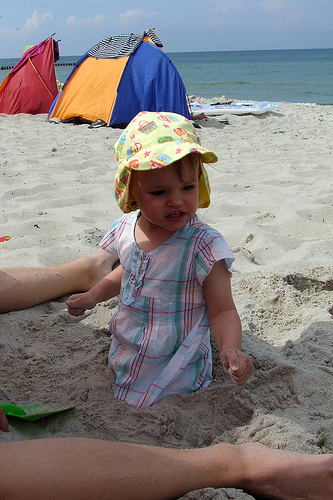

In [107]:
raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[199]))
preprocessed_img = preprocess(raw_img).to(DEVICE)
#TYPO?? :
#encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))
encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((1, 512))
caption = greedy_decoder(encoded_img)
print(caption)
raw_img

The result should look pretty good for most images, but the model is prone to hallucinations.

## Part V - Beam Search Decoder (24 pts)

**TODO** Modify the simple greedy decoder for the caption generator to use beam search.
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences.

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates.

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated.

Note that you cannot use the occurence of the `"<EOS>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam.

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n.

In [112]:
def img_beam_decoder(n, img):
    # began with greedy decoder from section IV

    init_sequence = ["<START>"]         # start sequence
    beam = []                           # beam: n highest-scoring sequences so far and their probability
    beam.append((1.0, init_sequence))   # probability of begining with "<START>" is 1

    prev_max = 0

    # until any of the sequences reach MAX_LEN
    # cannot use <EOS> to terminate b/c multiple locations in diff beam entries
    while all(len(i[1]) < MAX_LEN for i in beam):

      # for each sequence tuple in beam
      for sequence_tup in beam:

        prob = sequence_tup[0]        # probability of sequence
        sequence = sequence_tup[1]    # sequence
        idx = len(sequence)           # next index

        # pad sequence so len(sequence) = 40
        sequence = sequence + ["<PAD>"] * (MAX_LEN-idx)

        # encode the sequence using word_to_id
        with torch.no_grad():
          sequence_enc = torch.tensor([word_to_id[token] for token in sequence], dtype=torch.int64).unsqueeze(0)

          next_id = model(img.to(DEVICE), sequence_enc.to(DEVICE))  # calculate predictions using model
          next_id = torch.softmax(next_id, dim=-1)                  # apply softmax to convert outputs into a distribution
          next_id = next_id.to('cpu').numpy()                       # move to cpu and convert to numpy array

        # sort for most probable next tokens
        max_idxs = np.argsort(next_id[0, idx-1])[-n:][::-1]         # sorts distribution to create a list of n most probable indexes
        max_probs = next_id[0, idx-1][max_idxs]                     # get probability of n most probable indexes

        # remove pad
        sequence = sequence[:idx]

        # for each n most probable
        beam_update = []
        # get last word
        for i in range(n):
          last_word = sequence[idx-1]

          # <EOS> after '.' wp 100
          if last_word == "<EOS>":
            beam_update.append((prob * 1.0, sequence))
          else:
            next_word = id_to_word[max_idxs[i]]                                # calculate next word
            beam_update.append((prob * max_probs[i], sequence + [next_word]))  # update sequence with corresponding probability

      # prune the list to choose only the n most probable sequences
      beam = sorted(beam_update, key=lambda x: x[0], reverse=False)[:n]

      # TO CHECK BEAM AND PROBABILITES UNCOMMENT
      #print(beam)

      # if the maximum probability has not changed since the last pass
      # break the loop and return the sequence
      new_max = beam[n-1][0]
      if prev_max == new_max:
        break
      prev_max = new_max

    return sequence

**TODO** Finally, before you submit this assignment, please show 3 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5.

# Unsure why... but the PDF rendering is deleting the images so here they are

Greedy:		 ['<START>', 'a', 'brown', 'dog', 'is', 'running', 'on', 'a', 'grassy', 'field', '.', '<EOS>']
Beam n = 3:	 ['<START>', 'a', 'brown', 'dog', 'is', 'running', 'on', 'a', 'grassy', 'field', '.', '<EOS>']
Beam n = 5:	 ['<START>', 'a', 'brown', 'dog', 'is', 'running', 'on', 'a', 'grassy', 'field', '.', '<EOS>']


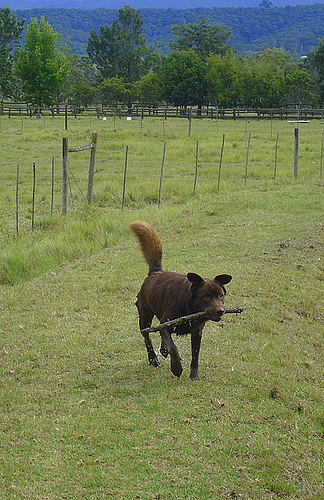

In [118]:
#Image processing
raw_img1 = PIL.Image.open(os.path.join(IMG_PATH, dev_list[50]))
preprocessed_img1 = preprocess(raw_img1).to(DEVICE)
encoded_img1 = img_encoder(preprocessed_img1.unsqueeze(0)).reshape((1, 512))

# greedy output
print('Greedy:\t\t', greedy_decoder(encoded_img1))

# beam search at n=3
print('Beam n = 3:\t', img_beam_decoder(3, encoded_img1))

# beam search at n=5
print('Beam n = 5:\t', img_beam_decoder(5, encoded_img1))

raw_img1

Greedy:		 ['<START>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'snow', '.', '<EOS>']
Beam n = 3:	 ['<START>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'snow', '.', '<EOS>']
Beam n = 5:	 ['<START>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'snow', '.', '<EOS>']


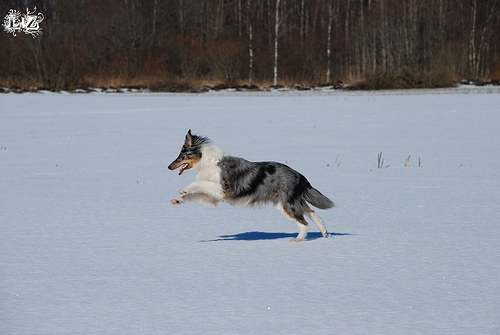

In [119]:
#Image processing
raw_img2 = PIL.Image.open(os.path.join(IMG_PATH, dev_list[700]))
preprocessed_img2 = preprocess(raw_img2).to(DEVICE)
encoded_img2 = img_encoder(preprocessed_img2.unsqueeze(0)).reshape((1, 512))

# greedy output
print('Greedy:\t\t', greedy_decoder(encoded_img2))

# beam search at n=3
print('Beam n = 3:\t', img_beam_decoder(3, encoded_img2))

# beam search at n=5
print('Beam n = 5:\t', img_beam_decoder(5, encoded_img2))

raw_img2

Greedy:		 ['<START>', 'a', 'boy', 'in', 'blue', 'shorts', 'and', 'a', 'blue', 'wetsuit', 'is', 'jumping', 'in', 'the', 'sand', '.', '<EOS>']
Beam n = 3:	 ['<START>', 'a', 'boy', 'in', 'blue', 'shorts', 'and', 'a', 'blue', 'wetsuit', 'is', 'jumping', 'in', 'the', 'sand', '.', '<EOS>']
Beam n = 5:	 ['<START>', 'a', 'boy', 'in', 'blue', 'shorts', 'and', 'a', 'blue', 'wetsuit', 'is', 'jumping', 'in', 'the', 'sand', '.', '<EOS>']


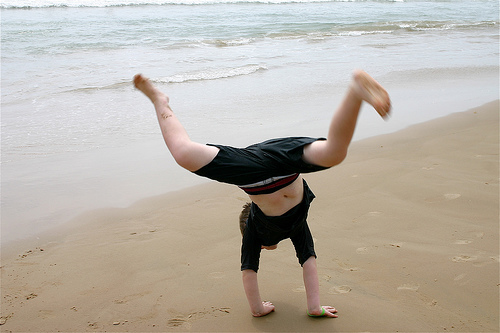

In [121]:
#Image processing
raw_img3 = PIL.Image.open(os.path.join(IMG_PATH, dev_list[987]))
preprocessed_img3 = preprocess(raw_img3).to(DEVICE)
encoded_img3 = img_encoder(preprocessed_img3.unsqueeze(0)).reshape((1, 512))

# greedy output
print('Greedy:\t\t', greedy_decoder(encoded_img3))

# beam search at n=3
print('Beam n = 3:\t', img_beam_decoder(3, encoded_img3))

# beam search at n=5
print('Beam n = 5:\t', img_beam_decoder(5, encoded_img3))

raw_img3



---





---

